# Experiment Results Visualization
This notebook visualizes the F1 scores from the `200k-hanna-data-sat` experiment, broken down by engineering method.

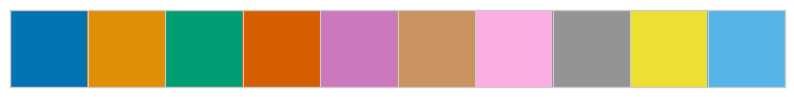

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Times"
plt.rcParams["font.weight"] = "light"

%matplotlib inline

import re
# establish and plot colorblind color pallete
colors = sns.color_palette('colorblind')
sns.set_palette(colors)
sns.palplot(colors)

In [ ]:
## to-dos: 
# 1. calculate per-engineering method
# 2. plot per-engineering method
# 3. add error bars across different seeds

In [26]:
import os
import glob
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score


def analyze_predictions_by_method():
    # Focus on the specific experiment directory
    search_path = '/home/maiwald/virus-engineer-detection/experiments/curated/200k-hanna-data-sat/*_predictions.csv'
    prediction_files = glob.glob(search_path, recursive=True)
    
    if not prediction_files:
        print(f"No prediction files found at {search_path}")
        return pd.DataFrame()

    results = []
    for file_path in prediction_files:
        try:
            # Extract method name from the filename
            filename = os.path.basename(file_path)
            method_part = filename.split('_', 2)[-1] # Remove timestamp
            method_name = method_part.replace('_predictions.csv', '')
            
            df = pd.read_csv(file_path)
            if 'true_label' not in df.columns or 'predicted_label' not in df.columns:
                print(f"Warning: {file_path} is missing required columns.")
                continue

            # 1. Calculate overall F1 score and count
            overall_score = f1_score(df['true_label'], df['predicted_label'])

            # lets print precision and recall as well
            precision = precision_score(df['true_label'], df['predicted_label'], zero_division=0)
            recall = recall_score(df['true_label'], df['predicted_label'], zero_division=0)
            print(f"Method: {method_name}, Precision: {precision:.4f}, Recall : {recall:.4f}, F1 Score: {overall_score:.4f}")

            overall_count = df['true_label'].sum()
            results.append({
                'method': method_name,
                'metric': 'overall',
                'f1_score': overall_score,
                'positive_examples': overall_count
            })

            

            # 2.
            # Add per engineering method analysis
            ### .... '''
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    # lets add a random baseline which always predicts the positive class
    random_f1 = f1_score(df['true_label'], [1]*len(df), zero_division=0)
    random_count = df['true_label'].sum()
    results.append({
        'method': 'random_baseline',
        'metric': 'overall',
        'f1_score': random_f1,
        'positive_examples': random_count
    })
        
    return pd.DataFrame(results)

results_df = analyze_predictions_by_method()
display(results_df)

Method: blast, Precision: 0.0254, Recall : 0.2462, F1 Score: 0.0461
Method: cnn, Precision: 0.7544, Recall : 0.0537, F1 Score: 0.1004
Method: multi_kmer, Precision: 0.0229, Recall : 0.3337, F1 Score: 0.0429
Method: kmer, Precision: 0.0583, Recall : 0.0612, F1 Score: 0.0597
Method: improved_cnn, Precision: 0.6618, Recall : 0.0563, F1 Score: 0.1037


,method,metric,f1_score,positive_examples
0,blast,overall,0.046082,800
1,cnn,overall,0.100350,800
2,multi_kmer,overall,0.042933,800
3,kmer,overall,0.059720,800
4,improved_cnn,overall,0.103687,800
5,random_baseline,overall,0.039216,800


In [27]:
# exclude multi-kmer and cnn 
results_df = results_df[~results_df['method'].str.contains('multi_kmer')]
results_df = results_df[~(results_df['method'] == 'improved_cnn')]

results_df

# rename methods to uppercase
results_df['method'] = results_df['method'].str.replace('blast', 'BLAST', regex=False)
results_df['method'] = results_df['method'].str.replace('kmer', 'k-mer based', regex=False)
results_df['method'] = results_df['method'].str.replace('random_baseline', 'Random Baseline', regex=False) 
results_df['method'] = results_df['method'].str.replace('cnn', 'CNN', regex=False)
results_df

,method,metric,f1_score,positive_examples
0,BLAST,overall,0.046082,800
1,CNN,overall,0.100350,800
3,k-mer based,overall,0.059720,800
5,Random Baseline,overall,0.039216,800


/home/maiwald/virus-engineer-detection/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/tmp/ipykernel_2198243/1338248363.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


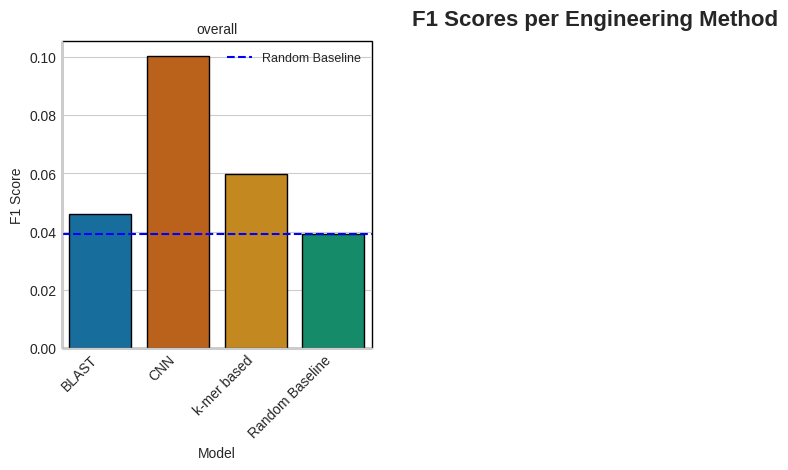

In [46]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Apply Aesthetic Settings from the file ---
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Times"
plt.rcParams["font.weight"] = "light"
plt.style.use('seaborn-v0_8-whitegrid')

# Establish the colorblind color palette
colors = sns.color_palette('colorblind')

# Define a color dictionary for your models to maintain consistency
# Populate this with your specific model names and a corresponding color
# You may need to add or change these based on the `method` names in your data
model_colors = {
    'BLAST': colors[0],
    'k-mer based': colors[1],
    'Random Baseline': colors[2],
    'CNN': colors[3],
}

if not results_df.empty:
    # Exclude 'overall' from engineering methods
    eng_df = results_df[results_df['method'] != 'random_baseline'].copy()

    # Use FacetGrid to create the plot
    g = sns.FacetGrid(eng_df, col='metric', col_wrap=3, height=4, sharey=True)
    
    # Map the barplot to the FacetGrid, using the custom color dictionary and black edges
    g.map_dataframe(sns.barplot, x='method', y='f1_score', palette=model_colors, edgecolor='black')
    
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Model", "F1 Score")
    
    for ax in g.axes.flat:
        # Add black borders to the entire plot
        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth(1)
        
        # Rotate x-axis labels
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
       
        
        # Add a horizontal line for the random baseline to each subplot
        random_f1 = results_df[results_df['method'] == 'Random Baseline']['f1_score'].values[0]
        ax.axhline(y=random_f1, color='blue', linestyle='--', label='Random Baseline')
        ax.legend(title='', loc='upper right', fontsize=9) # Add a legend to each subplot
        
    plt.subplots_adjust(top=0.9, wspace=0.3)
    g.fig.suptitle('F1 Scores per Engineering Method', fontsize=16, weight='bold')
    plt.show()
else:
    print("DataFrame is empty. No plot to generate.")

In [ ]:
## 